In [1]:
# What version of Python do you have?
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import re
import mne
from datetime import datetime
import pytz
import random
import os
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.6.0
Keras Version: 2.6.0

Python 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
Pandas 1.3.4
Scikit-Learn 1.0
GPU is available


In [2]:
from tensorflow.keras.applications import ResNet152, InceptionV3, InceptionResNetV2

In [3]:
inceptionV3 = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape = (299, 299, 3)
)

for layer in inceptionV3.layers:
    layer.trainable = True

In [4]:
inceptionV3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [5]:
resnet152 = ResNet152(
    weights='imagenet',
    include_top=False,
    input_shape=((224, 224, 3))
)

for layer in resnet152.layers:
    layer.trainable = True

reshaping = layers.Reshape((8, 8, 1568))(resnet152.output)
re_config_resnet152 = tensorflow.keras.Model(inputs=resnet152.input, outputs=reshaping)

In [6]:
a = np.zeros(shape=(7, 7, 2048))
a = a.reshape(8, 8, 1568)
a.shape

(8, 8, 1568)

In [7]:
re_config_resnet152.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [8]:

# sort losses of batch descending order
# the largest k? is averaged as the final loss
# return loss
# parameters needed: SUM, label(i), loss of batches


def ohem_loss(ytrue, ypred):
    result = K.categorical_crossentropy(ytrue, ypred, axis=-1)
    alpha = K.variable(0.1, dtype=tf.float32)
    index = K.greater(result, alpha)
    cast = tf.cast(index, tf.float32)
    return result*cast

In [9]:
from tensorflow.keras import Model
from tensorflow.keras import backend as K


concat_feature_layer = layers.concatenate([inceptionV3.output, re_config_resnet152.output])
fully_connected_dense_big = layers.Dense(1024, activation='relu')(concat_feature_layer)
dropout_one = layers.Dropout(0.5)(fully_connected_dense_big)
flatten_layer = layers.Flatten()(dropout_one)
fully_connected_dense_small = layers.Dense(512, activation='relu')(flatten_layer)
dropout_two = layers.Dropout(0.5)(fully_connected_dense_small)
fully_connected_dense_class = layers.Dense(4, activation='softmax')(dropout_two)

model = Model(
    inputs=[inceptionV3.input, re_config_resnet152.input],
    outputs=fully_connected_dense_class
)

model.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [10]:
modelplot = tensorflow.keras.utils.plot_model(model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [11]:
print(os.getcwd())
train_dir = "../windows/train"

c:\Users\45535\Desktop\speciale\DeepLearning_Master\Single_channel_models


In [12]:
resnet152_input_shape = (224, 224)
inceptionV3_input_shape = (299, 299)
batch_size =10

In [13]:
labels = [item for item in os.listdir(train_dir)]
labels = np.array(labels)
labels = labels[0:]
print(labels.shape)
labels

(4,)


array(['Interictal', 'Preictal_One', 'Preictal_Two', 'Seizure'],
      dtype='<U12')

In [14]:


generator = ImageDataGenerator(
  rescale=1./255
)

In [15]:
resnet_train_gen = generator.flow_from_directory(directory=train_dir,batch_size=batch_size, target_size=resnet152_input_shape, classes=list(labels))

Found 22497 images belonging to 4 classes.


In [16]:
inception_train_gen = generator.flow_from_directory(directory=train_dir,batch_size=batch_size, target_size=inceptionV3_input_shape, classes=list(labels))

Found 22497 images belonging to 4 classes.


In [17]:
def generator_two_img():
    resnet_train_gen = generator.flow_from_directory(directory=train_dir,batch_size=batch_size, target_size=resnet152_input_shape, classes=list(labels))
    inception_train_gen = generator.flow_from_directory(directory=train_dir,batch_size=batch_size, target_size=inceptionV3_input_shape, classes=list(labels))
    while True:
        X1i = inception_train_gen.next()
        X2i = resnet_train_gen.next()
        yield [X1i[0], X2i[0]], X1i[1]

In [18]:
def show_batch(image, label):
  plt.figure(figsize=(10,10))
  for n in range(10):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image[n])
      plt.title(labels[label[n].argmax()])
      plt.axis('off')

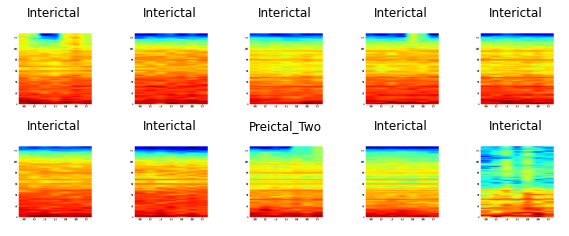

In [19]:
image, label = next(resnet_train_gen)
show_batch(image, label)

In [20]:
inception_train_gen.samples//16

1406

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("singleChannelModelWeight", monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [22]:
# history = model.fit(
#     x=generator_two_img(),
#     epochs=3,
#     batch_size=batch_size,
#     steps_per_epoch = inception_train_gen.samples//batch_size,
#     callbacks=callbacks_list
# )

In [23]:
#model.save("singleChannelModel.h5")

In [24]:
model = tensorflow.keras.models.load_model("./singleChannelModel")

In [25]:
test_dir = "../windows/train"

In [26]:
len([item for item in os.listdir(test_dir + '/' + 'Seizure')])

219

In [27]:
def limit_data_samples(data_dir, n=1):
  a = []
  for i in os.listdir(data_dir):
    for index, item in enumerate(os.listdir(data_dir+'/'+i)):
      if index > n:continue
      a.append((f'{data_dir}/{i}/{item}',i))
  return  pd.DataFrame(a, columns=['filename', 'class'])

In [28]:
test_df = limit_data_samples(test_dir)

In [29]:
def test_generator_two_img():
    resnet_train_gen = generator.flow_from_dataframe(dataframe=test_df,batch_size=batch_size, target_size=resnet152_input_shape, classes=list(labels), shuffle=False)
    inception_train_gen = generator.flow_from_dataframe(dataframe=test_df,batch_size=batch_size, target_size=inceptionV3_input_shape, classes=list(labels), shuffle=False)
    while True:
        X1i = inception_train_gen.next()
        X2i = resnet_train_gen.next()
        yield [X1i[0], X2i[0]], X1i[1]

y_pred_generator = test_generator_two_img()

In [30]:
info_gen = generator.flow_from_dataframe(dataframe=test_df,batch_size=batch_size, target_size=resnet152_input_shape, classes=list(labels), shuffle=False)

test_steps = generator.flow_from_dataframe(dataframe=test_df,batch_size=batch_size, target_size=resnet152_input_shape, classes=list(labels), shuffle=False).samples // batch_size
test_steps

Found 8 validated image filenames belonging to 4 classes.
Found 8 validated image filenames belonging to 4 classes.


0

In [31]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

img = load_img("C:/Users/45535/Desktop/speciale\DeepLearning_Master/windows/test/Seizure/chb10_12_0_F3-C3_18-40-13.png", target_size=resnet152_input_shape)
img2 = load_img("C:/Users/45535/Desktop/speciale\DeepLearning_Master/windows/test/Seizure/chb10_12_0_F3-C3_18-40-13.png", target_size=inceptionV3_input_shape)


def format_img(my_image):
  my_image = img_to_array(my_image)
  my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
  my_image = preprocess_input(my_image)
  return my_image

img = format_img(img)
img2 = format_img(img2)

In [32]:
y_pred = model.predict([img2, img])

In [33]:
y_pred

array([[2.1424009e-06, 1.1895049e-09, 9.9999785e-01, 0.0000000e+00]],
      dtype=float32)

In [34]:
from sklearn.metrics import classification_report


In [36]:
labels

array(['Interictal', 'Preictal_One', 'Preictal_Two', 'Seizure'],
      dtype='<U12')

In [40]:
y_pred[i].argmax()

2

In [43]:
import PIL
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

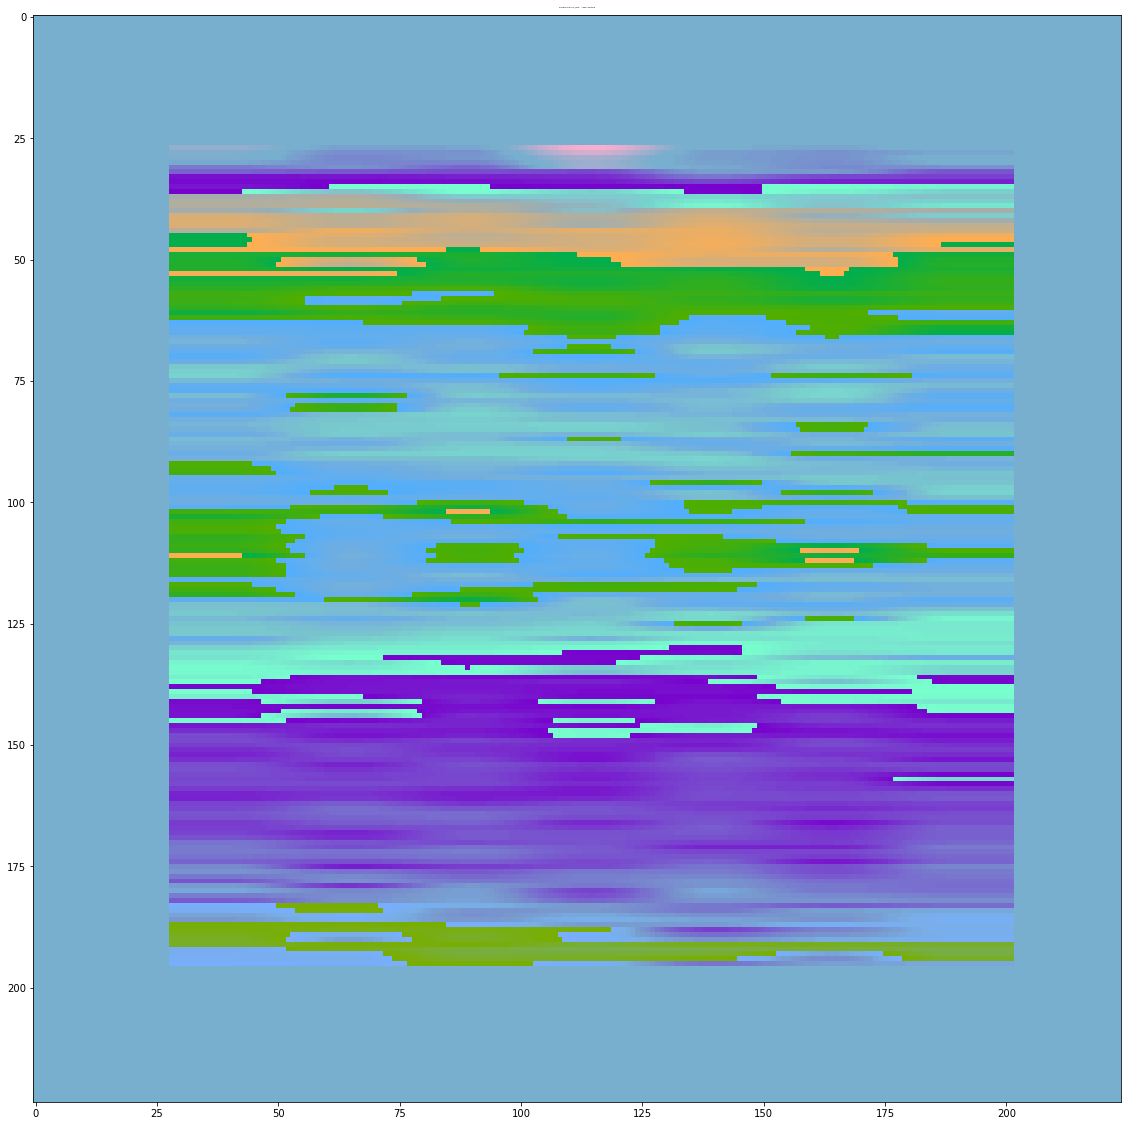

In [47]:
plt.figure(figsize=(20,20))


for i in range(1):
    pred = y_pred[i].argmax()
    plt.subplot(1,1,i+1)
    plt.imshow(tensor_to_image(img))
    title_ = 'Predict:' + str(labels[pred])+ ';   Label:' + "Seizure"
    plt.title(title_,size=2)
plt.show()

In [ ]:
predicted_classes = np.argmax(y_pred, axis=1)
predicted_classes

array([2], dtype=int64)

In [ ]:
true_classes = 
class_labels = list(info_gen.class_indices.keys()) 
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(y_pred, axis=1)

conf_mat = confusion_matrix(y_test, y_pred)